In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

# Lecture des données

In [12]:
def lecture(fichier):
    with open(fichier, "r") as f:
        nt = []
        re = []
        im = []
        for line in f:
            data = line.split()
            nt.append(data[0])
            re.append(data[1])
            im.append(data[2])
        nt = nt[1:]
        re = re[1:]
        im = im[1:]
        for i in range(len(nt)):
            nt[i] = float(nt[i])
            re[i] = float(re[i])
            im[i] = float(im[i])
        return nt, re, im

In [13]:
fichier = "pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz8.m-0.3303_m-0.3303.n3.dat"
nt, re, im = lecture(fichier)

In [14]:
#listes par configurations
def par_configs(nt,re,im):
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    return ntll, rell, imll

In [15]:
ntll, rell, imll = par_configs(nt,re,im)

In [16]:
#retourne la norme par nt
def normes_par_nt(ntll, rell, imll):
    nont = []
    for i in range(64):
        nonti = []
        for j in range(len(ntll)):
            nonti.append(np.sqrt((rell[j])[i]**2 + (imll[j])[i]**2))
        nont.append(nonti)
    return nont

In [17]:
def re_im_par_nt(rell, imll):
    rent = []
    imnt = []
    for i in range(64):
        renti = []
        imnti = []
        for j in range(len(rell)):
            renti.append(rell[j][i])
            imnti.append(imll[j][i])
        rent.append(renti)
        imnt.append(imnti)
    return rent, imnt

In [18]:
nont = normes_par_nt(ntll, rell, imll)

In [19]:
rent, imnt = re_im_par_nt(rell, imll)

# Premier fit

In [20]:
def moyenne_norme(nont): #renvoie une liste avec les moyennes des normes pour chaque nt, et la liste des erreurs stats associées
    return [np.mean(nont[i]) for i in range(len(nont))], [np.sqrt(np.var(nont[i])) for i in range(len(nont))]

In [21]:
def moyenne_re_im(rent, imnt):
    return [np.mean(rent[i]) for i in range(len(rent))], [np.sqrt(np.var(rent[i])) for i in range(len(rent))], [np.mean(imnt[i]) for i in range(len(imnt))], [np.sqrt(np.var(imnt[i])) for i in range(len(imnt))]

In [22]:
remoy, sigmare, immoy, sigmaim = moyenne_re_im(rent, imnt)

In [25]:
nomoy, sigmaobs = moyenne_norme(nont)
xnt = [i for i in range(64)]

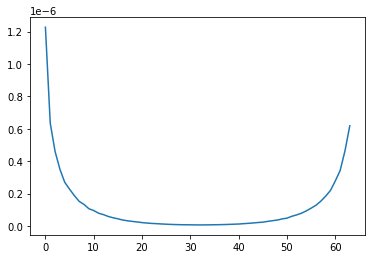

In [26]:
#count,bins  = np.histogram(np.array(immoy)/np.array(remoy))
remoy=np.array(remoy)
plt.plot((nomoy))

Text(0, 0.5, '$ln(C(n_t))$')

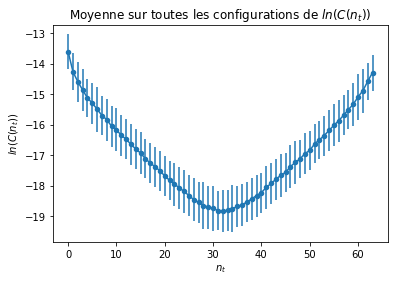

In [27]:
plt.errorbar(xnt,np.log(nomoy), (sigmaobs/np.abs(nomoy)), marker='.', mew=2.5)
plt.title("Moyenne sur toutes les configurations de $ln(C(n_t))$")
plt.xlabel(r"$n_t$")
plt.ylabel(r"$ln(C(n_t))$")

In [28]:
def fit(nt, A0, E0): #la fonction à fit
    return A0*np.cosh((nt-32)*E0)

In [29]:
def estim(inf,sup, nomoy, sigmaobs): #renvoie [A0, E0, chi2, chi2réduit], xdata, ydata, ypred
    xdata = np.array([i for i in range(inf,sup)])
    ydata = np.array(nomoy[inf:sup])
    sigmadata = np.array(sigmaobs[inf:sup])
    popt, pcov = curve_fit(fit, xdata, ydata, sigma = sigmadata)
    A0 = popt[0]
    E0 = popt[1]
    ddl = sup-inf+1-2
    ypred = fit(xdata, A0, E0)
    chi2 = np.sum(((ydata-ypred)/sigmadata)**2)
    chi2red = chi2/ddl
    return [A0, E0, chi2, chi2red], xdata, ydata, ypred, sigmadata

# Effective mass plateau

In [30]:
def plateau(nomoy, sigmaobs):
    chi2 = []
    for i in range(2,31):
        params, xdata, ydata, ypred, sigmadata = estim(31-i, 31+i, nomoy, sigmaobs)
        chi2.append(params[2])
            
    dernier_indice_satisfaisant = -1  # Initialisation avec un indice invalide au cas où aucun élément ne satisfait la condition
    #print(chi2)
    for i, valeur in enumerate(chi2):
        if valeur < 1:
            dernier_indice_satisfaisant = i
    dernier_indice_satisfaisant = dernier_indice_satisfaisant+2
    inf = 31-dernier_indice_satisfaisant
    sup = 31+dernier_indice_satisfaisant
    #print("inf = " + str(inf))
    #print("sup = " + str(sup))
    return inf, sup

In [31]:
inf, sup = plateau(nomoy, sigmaobs)

In [32]:
print(inf, sup)

13 49


On choisit donc comme plateau (13,49) :

In [34]:
params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
print(params[2])

0.022371239783129226


Text(0, 0.5, '$C(n_t)$')

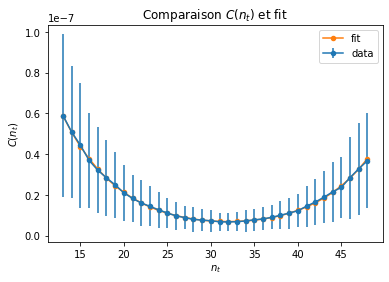

In [35]:
plt.errorbar(xdata, ydata, sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, ypred, marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $C(n_t)$ et fit")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$C(n_t)$")

In [36]:
a =  0.0652
x = (1/a)*197.327
E0 = params[1]
Mphysmev = E0*x
print("Masse physique : " + str(Mphysmev) + " MeV")

Masse physique : 451.8517202568747 MeV


# Détermination des erreurs

## Jacknife

In [37]:
nconf = 999
a =  0.0652
x = (1/a)*197.327

In [38]:
def jack(n, nt, re, im): #retourne les listes des nt, re, im par configuration ou il manque la nième configuration
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    ntll.pop(n)
    rell.pop(n)
    imll.pop(n)
    return ntll, rell, imll

In [52]:
def jacknife(nconf, fichier, a, x):
    nt, re, im = lecture(fichier)
    E0jn = [] #liste des E0 pour chaque set du jacknife
    
    ntll, rell, imll = par_configs(nt,re,im)
    nont = normes_par_nt(ntll, rell, imll)
    nomoy, sigmaobs = moyenne_norme(nont)
    inf,sup = plateau(nomoy, sigmaobs)
    params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
    
    E0 = params[1] #on trouve E0 sans jacknife d'abord
    
    for n in range(nconf): #on fait le jacknife
        
        ntll, rell, imll = jack(n,nt,re,im)
        
        nont = normes_par_nt(ntll, rell, imll)
        
        nomoy, sigmaobs = moyenne_norme(nont)
        
        inf,sup = plateau(nomoy, sigmaobs)
        
        params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
        
        E0jn.append(params[1])
        
        if (n%100==0): #compteur
            print(n)
            
    E0tild = np.mean(np.array(E0jn))
    biais = (len(E0jn)-1)*(E0tild-E0)
    E0unb = E0 - biais
    sigmajn2 = np.sqrt(np.var(E0jn))#unbiased estimator for E0
    sigmajn = np.sqrt(((nconf-1)/nconf)*np.sum((np.array(E0jn) - np.ones(nconf)*E0)**2))  #Erreur sur E0 estimée par le jacknife
    
    print("\n")
    print("biais = " + str(biais*x))
    print("\n")
    print("E0 tild= " + str(E0tild) + " +/- " + str(sigmajn))
    print("M tild = " + str(E0tild*x) + " +/- " + str(sigmajn*x) + " MeV")
    print("\n")
    print("E0 unbiased= " + str(E0unb) + " +/- " + str(sigmajn))
    print("M unbiased = " + str(E0unb*x) + " +/- " + str(sigmajn*x) + " MeV")
    print("\n")
    print("E0 biased= " + str(E0) + " +/- " + str(sigmajn))
    print("M biased = " + str(E0*x) + " +/- " + str(sigmajn*x) + " MeV")
    return E0jn, E0, E0unb, sigmajn
    

In [53]:
E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)

0
100
200
300
400
500
600
700
800
900


biais = 272.96388417018244


E0 tild= 0.14938941488908392 +/- 0.00559427038383917
M tild = 452.12523116285683 +/- 16.930990675334847 MeV


E0 unbiased= 0.05910740503252132 +/- 0.00559427038383917
M unbiased = 178.8878360866923 +/- 16.930990675334847 MeV


E0 biased= 0.14929904250684511 +/- 0.00559427038383917
M biased = 451.8517202568747 +/- 16.930990675334847 MeV


## Bootstrap

In [54]:
def create_set(nt, re, im, nconf):
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    conf = [i for i in range(nconf)]
    ind = random.choices(conf,k=nconf)
    ntll = [ntll[i] for i in ind]
    rell = [rell[i] for i in ind]
    imll = [imll[i] for i in ind]
    return ntll, rell, imll

In [55]:
def bootstrap(nbs, nconf, fichier, a, x):
    nt, re, im = lecture(fichier)
    E0bs = []
    
    for n in range(nbs):
        
        ntll, rell, imll = create_set(nt, re, im, nconf)
        
        nont = normes_par_nt(ntll, rell, imll)
        
        nomoy, sigmaobs = moyenne_norme(nont)
        
        inf,sup = plateau(nomoy, sigmaobs)
        
        params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
        
        E0bs.append(params[1])
        
        if (n%100==0): #compteur
            print(n)
    
    E0bstild = np.mean(np.array(E0bs))  #estimator for E0
    sigmabs = np.sqrt(np.var(E0bs)) #error for E0 by bootstrapping
    
    print("\n")
    print("E0 = " + str(E0bstild) + " +/- " + str(sigmabs))
    print("M = " + str(E0bstild*x) + " +/- " + str(sigmabs*x) + " MeV")
    
    return E0bs, E0bstild, sigmabs

In [56]:
nbs = 999
nconf = 999
a =  0.0652
x = (1/a)*197.327

E0bs, E0bstild, sigmabs = bootstrap(nbs, nconf, fichier, a, x)

0
100
200
300
400
500
600
700
800
900


E0 = 0.14937740735035743 +/- 0.0007660801777568956
M = 452.0888904942329 +/- 2.3185322582244625 MeV


Masse trop grande ? Biais trop grand ? Vérifions que le biais diminue lorsque les configurations augmentent

In [72]:
def supprimer_n_conf(nconf, n, nt, re, im): #retourne les listes des nt, re, im ou il manque n configurations
    ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
    rell = [re[i:i+64] for i in range(0, len(re),64)]
    imll = [im[i:i+64] for i in range(0, len(im),64)]
    conf_suppr = random.sample(range(nconf), n)
    ntll = [element for i, element in enumerate(ntll) if i not in conf_suppr]
    rell = [element for i, element in enumerate(rell) if i not in conf_suppr]
    imll = [element for i, element in enumerate(imll) if i not in conf_suppr]
    nt2 = [element for sous_liste in ntll for element in sous_liste]
    re2 = [element for sous_liste in rell for element in sous_liste]
    im2 = [element for sous_liste in imll for element in sous_liste]
    return nt2, re2, im2

In [73]:
with open("pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz8.m-0.3303_m-0.3303.n3.dat", "r") as f:
    nt = []
    re = []
    im = []
    for line in f:
        data = line.split()
        nt.append(data[0])
        re.append(data[1])
        im.append(data[2])
    nt = nt[1:]
    re = re[1:]
    im = im[1:]
    for i in range(len(nt)):
        nt[i] = float(nt[i])
        re[i] = float(re[i])
        im[i] = float(im[i])

In [85]:
biais = []
liste_E0 = []
liste_sig = []
biaisrel = []
nbconfs = []

for i in range(50,999,100):
    nbconfs.append(i)
    nt2,re2,im2 = supprimer_n_conf(nconf, nconf-i, nt, re, im)
    E0jn, E0, E0unb, sigmajn = jacknife(i, nt2, re2, im2, a, x)
    biais.append(E0-E0unb)
    liste_E0.append(E0)
    liste_sig.append(sigmajn)
    biaisrel.append((E0-E0unb)/E0unb)
    print(i)

0


E0 unbiased= 0.11068823055691956 +/- 0.00826350928209963
M unbiased = 334.9965716427189 +/- 25.009409449522607 MeV


E0 biased= 0.15166400484061301 +/- 0.00826350928209963
M biased = 459.0092497420805 +/- 25.009409449522607 MeV
50
0
100


E0 unbiased= 0.11573403961197731 +/- 0.004945568767257247
M unbiased = 350.2676508360836 +/- 14.967703192278696 MeV


E0 biased= 0.1493733528522974 +/- 0.004945568767257247
M biased = 452.0766196056026 +/- 14.967703192278696 MeV
150
0
100
200


E0 unbiased= 0.19998196303517238 +/- 0.006162368919124249
M unbiased = 605.2429573595317 +/- 18.650333921840964 MeV


E0 biased= 0.14857626051322015 +/- 0.006162368919124249
M biased = 449.66422942165946 +/- 18.650333921840964 MeV
250
0
100
200
300


E0 unbiased= 0.046766353466034305 +/- 0.008542792550960378
M unbiased = 141.5377949446649 +/- 25.85465683594109 MeV


E0 biased= 0.14781926423033398 +/- 0.008542792550960378
M biased = 447.3731894598024 +/- 25.85465683594109 MeV
350
0
100
200
300
400


E0 unbia

C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


200
300
400
500
600


E0 unbiased= -0.0676498418038885 +/- 0.009543019070271505
M unbiased = -204.74141616005994 +/- 28.881830123918185 MeV


E0 biased= 0.14897721433178732 +/- 0.009543019070271505
M biased = 450.87771123387427 +/- 28.881830123918185 MeV
650
0
100
200
300
400
500
600
700


E0 unbiased= 0.249276302486925 +/- 0.006869178552327753
M unbiased = 754.4316708717402 +/- 20.789484604220533 MeV


E0 biased= 0.14917735417523798 +/- 0.006869178552327753
M biased = 451.48343201437405 +/- 20.789484604220533 MeV
750
0
100
200
300
400
500
600
700
800


E0 unbiased= 0.17577860255492173 +/- 0.005634093451929534
M unbiased = 531.9917838398013 +/- 17.051514702283733 MeV


E0 biased= 0.14942053036261613 +/- 0.005634093451929534
M biased = 452.21940176171717 +/- 17.051514702283733 MeV
850
0
100
200
300
400
500
600
700
800
900


E0 unbiased= 0.07074342912107912 +/- 0.00587263235989121
M unbiased = 214.10412021741075 +/- 17.773449780371976 MeV


E0 biased= 0.14939865143670247 +/- 0.0058726323

Text(0, 0.5, 'Biais')

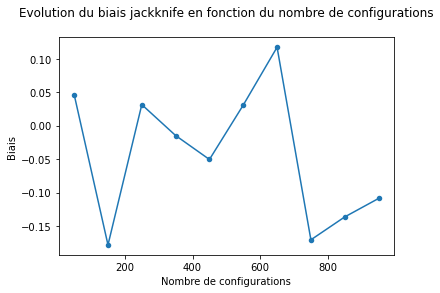

In [75]:
plt.plot(nbconfs, biais,marker=".", mew=2.5)
plt.title("Evolution du biais jackknife en fonction du nombre de configurations"+"\n")
plt.xlabel("Nombre de configurations")
plt.ylabel("Biais")


Text(0, 0.5, 'Masse du pion (MeV)')

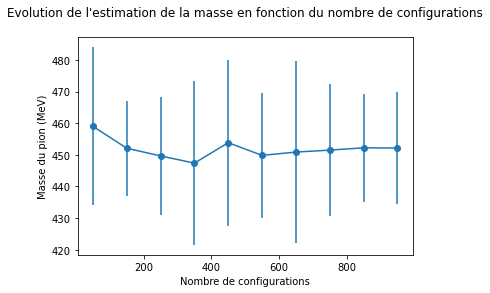

In [96]:
plt.errorbar(nbconfs, np.array(liste_E0)*x, np.array(liste_sig)*x, marker="o")
plt.title("Evolution de l'estimation de la masse en fonction du nombre de configurations"+"\n")
plt.xlabel("Nombre de configurations")
plt.ylabel("Masse du pion (MeV)")